# NEURAL NETWORKS AND DEEP LEARNING PROJECT

---
A.A. 2023/24 (6 CFU) - Giuseppe Labate, Sana Amiri
---

## Project 1 - Car classification, attribute prediction and car verification

In this project

1.   **Classification** car images given cars dataset CompCars.

2.   **Attributes prediction** based on the images.  
        Attributes for this project are:  
    1. Explicit Attributes:  
    	1. Number of doors  
    	2. Number of seats  
    	3. Type of car  
	2. Implicit Attributes:  
    	4. Max speed  
    	5. Displacement  


In [1]:
# from google.colab import drive
import os

# drive.mount('/content/drive')
# data = '/content/drive/My Drive/Deep_Project/data'

In [2]:
## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
# %matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')  # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
# sns.set()  ---> Uncomment if you want to use seaborn themes

## tqdm for loading bars
from tqdm.notebook import tqdm
import os
import random
## NumPy
import numpy as np
## PyTorch
import torch
import torch.nn as nnpo
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import scipy.io
import time
from torch.autograd import Variable

## Torchvision
import torchvision   # For Computer Vision tasks
from torchvision import transforms   # Transforms for images for data augmentation


# Path to the folder where the datasets are/should be downloaded
DATA_PATH = os.path.join(".", "Deep_Project", "data")  # Change this path to your desired location

NUM_WORKERS = 0 #os.cpu_count()

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
generator = torch.Generator().manual_seed(seed) # For explicit splitting and/or shuffling

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Device: cuda:0
Number of workers: 0


<Figure size 640x480 with 0 Axes>

In the next code snippet, we will perform DataLoading of the dataset contained in `./Deep_Project/data`. The dataset will be split according to the splitting files located in the `train_test_split` folder.

FROM HERE THE CODE IS USED TO CROP THE DATASET AND LOAD IT CORRECTLY WITH THE RIGHT LABEL


In [3]:
####MODIFICA ALLA FUNZIONE SAVE_CROP_IMAGES###
#HERE THE FUNCTION HAS TO SAVE THE IMAGES IN THE FOLDER CROPPED_IMAGES/DIRECTORY OF THE FULL IMAGE
#FOR EXAMPLE, IF THE FULL IMAGE IS IN THE FOLDER "image/AM General Hummer SUV 2000" THE CROPPED IMAGE HAS TO BE SAVED IN "cropped_images/classification/train/AM General Hummer SUV 2000"
#WE WANT ALSO TO DO IT WITHOUT USING CROPDATASET FUNCTION

from PIL import Image
import torchvision.transforms as transforms

# Path to the folder where the datasets are/should be downloaded
image_dir = os.path.join(DATA_PATH, "image")
label_dir = os.path.join(DATA_PATH, "label")
train_list = os.path.join(DATA_PATH, "train_test_split", "classification", "train.txt")
test_list = os.path.join(DATA_PATH, "train_test_split", "classification", "test.txt")

def crop_image(image, bbox):
	x1, y1, x2, y2 = bbox
	image_np = np.array(image)
	return image_np[y1:y2, x1:x2]

#Loads the viewpoint and bounding box from the label file
def load_label(label_path):
	with open(label_path, 'r') as f:
		lines = f.readlines()
		viewpoint = int(lines[0].strip())
		bbox = list(map(int, lines[2].strip().split()))
	return viewpoint, bbox

def save_cropped_images(file_list, output_dir):
	# Create the output directory if it does not exist
	if not os.path.exists(output_dir):
		os.makedirs(output_dir)

		# Access to the image paths and labels
		with open(file_list, 'r') as f:
			for line in tqdm(f, desc="Saving images"):
				image_path = os.path.join(image_dir, line.strip())
				label_path = os.path.join(label_dir, line.strip()).replace('.jpg', '.txt')
				car_properties = load_label(label_path)
				# Dividing the label path into car make, model and year
				label_path_parts = line.strip().split('/')

				# Given the values of labels path, put the correct car make, model and year in the output directory
				output_image_dir = os.path.join(output_dir, label_path_parts[0], label_path_parts[1], label_path_parts[2])
				os.makedirs(output_image_dir, exist_ok=True)

				# Load the image
				image = Image.open(image_path).convert("RGB")

				# Crop the image
				cropped_image = crop_image(image, car_properties[1])
				cropped_image = transforms.ToPILImage()(cropped_image)

				# Save the cropped image
				output_image_path = os.path.join(output_image_dir, os.path.basename(image_path))
				cropped_image.save(output_image_path)

def get_names(mat_file, labels):
	# Load the make and model names from the .mat file
	mat_data = scipy.io.loadmat(mat_file)
	make_names = mat_data['make_names']
	model_names = mat_data['model_names']
	make_name = make_names[int(labels[0]) - 1][0].item()
	model_name = model_names[int(labels[1]) - 1][0].item()
	return make_name, model_name

# Example usage
class_dir = os.path.join(DATA_PATH, "cropped_image", "classification")
train_val_path = os.path.join(class_dir, "train_val")
test_path = os.path.join(class_dir, "test")

print("test", test_path)
print("train", train_val_path)
save_cropped_images(train_list, train_val_path)
save_cropped_images(test_list, test_path)


test .\Deep_Project\data\cropped_image\classification\test
train .\Deep_Project\data\cropped_image\classification\train_val


In [4]:
#### DATA LOADER FOR CROPPED IMAGES ####
from torch.utils.data import Dataset, DataLoader

class CroppedCarDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform

		# Save the images contained in image_dir
        self.image_paths = []
        for root, _, files in os.walk(image_dir):
            for file in files:
                if file.endswith(".jpg"):
                    self.image_paths.append(os.path.join(root, file))

		# Save the labels
        self.car_make = []
        self.car_model = []
        for image_path in self.image_paths:
            label = image_path.split(os.sep)[-4:-1]  # Car make, model, year
            #Get labels from the image path, append them to the lists, and convert them to tensors of type long
            self.car_make.append(int(label[0]))
            self.car_model.append(int(label[1]))

		# # Load the make and model names from the .mat file
        # mat_data = scipy.io.loadmat(mat_file)
        # self.make_names = mat_data['make_names']
        # self.model_names = mat_data['model_names']

	#Returns the image, viewpoint, bounding box and label path
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert("RGB")

        # make_name = self.make_names[int(labels[0]) - 1][0].item()
        # model_name = self.model_names[int(labels[1]) - 1][0].item()
        # year = labels[2]

        #label = [make_name, model_name, year]
        car_make = self.car_make[index]
        car_model = self.car_model[index]

        if self.transform:
            image = self.transform(image)

        return image, car_make, car_model

    def __len__(self):
        return len(self.image_paths)

print("Data loading is complete.")



Data loading is complete.


### Calculating the mean and std

In [5]:
# def calculate_mean_std(dataset):
#     loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=NUM_WORKERS)
#     mean = 0.0
#     std = 0.0
#     total_samples = 0

#     for images, _, _ in tqdm(loader):  # Assume the dataset returns (image, label)
#         # Convert images to float tensors
#         images = images.float()
#         batch_samples = images.size(0)  # Number of images in the batch
#         total_samples += batch_samples

#         # Calculate mean and sum of squares per channel
#         mean += images.mean(dim=[0, 2, 3]) * batch_samples
#         std += images.std(dim=[0, 2, 3]) * batch_samples

#     mean /= total_samples
#     std /= total_samples

#     return mean, std

# # Create the dataset
# to_tensor_train = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize images to a common size
#     transforms.ToTensor()
# ])
# train_val_dataset_denorm = CroppedCarDataset(train_path, transform=to_tensor_train)
# train_len = int(0.7*len(train_val_dataset_denorm))  # 70% training
# val_len = len(train_val_dataset_denorm) - train_len	# 30% validation

# # Split the dataset into training and validation sets
# # Set the seed for reproducibility so that the split is the same every time
# train_dataset_denorm, _ = torch.utils.data.random_split(train_val_dataset_denorm, [train_len, val_len], generator=generator)
# # Calculate the mean and standard deviation of the training dataset
# mean, std = calculate_mean_std(train_dataset_denorm)

# print("Mean:", mean)
# print("Std:", std)

In the following cell, I will create a transformation composition that will be applied to the images in our dataset. This transformation is crucial for preprocessing the images before they are fed into our machine learning model. The preprocessing steps may include operations such as resizing, normalization, augmentation, and other techniques to enhance the quality and variability of the training data. By applying these transformations, we aim to improve the model's performance and generalization capabilities. Let's proceed with defining this transformation function in the next cell.

In [6]:
from torchvision.transforms import RandomAffine, RandomHorizontalFlip, RandomVerticalFlip

# If you have already calculated the mean and standard deviation, you can directly assign them here
##################TODO################## USE THE MEAN AND STD CALCULATED ABOVE
mean = [0.4262, 0.4063, 0.4067]
std = [0.2830, 0.2794, 0.2830]

##### TRANSFORMS #####
base_transform = transforms.Compose([
	transforms.Resize((224, 224)),
	transforms.ToTensor(),
	transforms.Normalize(mean, std),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform1 = transforms.Compose([
	transforms.Resize((224, 224)),
	RandomAffine((0.05, 0.05)),
	transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
  	RandomHorizontalFlip(),
    transforms.CenterCrop(224),
    transforms.RandomRotation(10),
    #transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
	transforms.Normalize(mean, std),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

augmentation_transforms = transforms.Compose([
	RandomAffine((0.05, 0.05)),
	transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
  	RandomHorizontalFlip(),
    transforms.CenterCrop(224),
    transforms.RandomRotation(15),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
])

transform2 = transforms.Compose([
				transforms.Normalize(mean, std),
                transforms.RandomRotation(10),
				#transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
				])


transform3 = transforms.Compose([
	transforms.Resize((299, 299)),  # Inception v3 requires 299x299 input size
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
# Path to the folder where the datasets are/should be downloaded
mat_file = os.path.join(DATA_PATH, "misc" ,"make_model_name.mat")

# Create the datasets
train_val_dataset = CroppedCarDataset(image_dir=train_val_path, transform=transform1) #dataset that contains train and validation datasets
train_len = int(0.7*len(train_val_dataset))  # 70% training
val_len = len(train_val_dataset) - train_len	# 30% validation

train_dataset, val_dataset = data.random_split(train_val_dataset, [train_len, val_len], generator=generator) #split the dataset into train and validation datasets

test_dataset = CroppedCarDataset(image_dir=test_path, transform=base_transform)   #dataset that contains test dataset

Let's see if the dataset is not balanced

In [8]:
# Function to apply random augmentations to an image
def apply_augmentation(image):
    transform = random.choice(augmentation_transforms)  # Randomly select a transform
    return transform(image)


def augment_class_samples(dataset, target_class, num_new_samples):
    augmented_images = []
    for _ in range(num_new_samples):
        img, make, model = dataset[random.choice([i for i, (_, make, _) in enumerate(dataset) if make == target_class])]
        augmented_img = apply_augmentation(img)
        augmented_images.append((augmented_img, make, model))
    return augmented_images

In [9]:
############################################################
# Function to count the number of images per car make
############################################################

from collections import Counter
def count_labels(dataset, make = True):
	# Extracts the labels from the dataset
	if make:
		list = [make for _, make, _ in dataset]
	else:
		list = [model for _, _, model in dataset]

	# Counts the occurrences of each label
	dataset_count = Counter(list)

	# Transform the labels into the string using get_names function
	if make:
		dataCount_names = {tuple(get_names(mat_file, [label, 0]))[0]: count for label, count in tqdm(dataset_count.items())}
	else:
		dataCount_names = {tuple(get_names(mat_file, [0, label]))[1]: count for label, count in tqdm(dataset_count.items())}

	# Print the labels and their counts
	print("Dataset labels:", dataCount_names)

	# Sort the labels by alphabetical order
	sorted_labels = sorted(dataCount_names.items(), key=lambda x: x[0])
	labels, counts = zip(*sorted_labels)

	# Create the plot
	plt.figure(figsize=(15, 5))
	plt.bar(labels, counts)
	plt.xticks(rotation=90)
	plt.ylabel("Number of images")
	plt.title("Number of images per car make in the training dataset")
	plt.show()

	return dataset_count

#train_counts = count_labels(train_dataset)
#print(train_counts)

In [10]:

# from PIL import Image
# import torchvision.transforms as transforms

# # Apply the transformation to each image in the dataset
# train_dataset_augmented = [(transform1((train_dataset[i][0])), train_dataset[i][1], train_dataset[i][2]) for i in tqdm(range(len(train_dataset)))]

In [11]:
# Apply the transformation to each image in the validation dataset
#val_dataset = [(base_transform((val_dataset[i][0])), val_dataset[i][1], val_dataset[i][2]) for i in tqdm(range(len(val_dataset)))]

In [12]:
# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)

### Test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5060071..2.0406964].


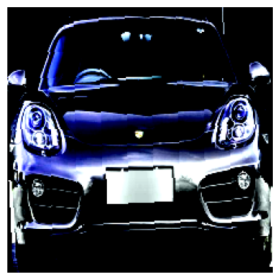

Make: 48
Model: 326
0
torch.Size([32, 3, 224, 224])
tensor([ 28,  97,  73, 134, 100,  77, 140, 142, 100,  73, 152,  53,  35, 102,
         39, 102,  82,  39,  77,  73,  39,  78,  27, 118,  78, 100, 162,  38,
        152,  78,  48,  77])
tensor([1885,  854,  465,  661,  211,  126, 1200, 1137,  251,  440,  397,  764,
         559,  293, 1328,  263,  344, 1386,  126,  465, 1326,   32, 1070,  980,
           3,  251, 1634, 1952,  398,   32,  317,  152])
('Porsche', 'Cayman')
Number of images in the training set: 11211
Number of images in the validation set: 4805
Number of images in the test set: 14939
Image shape: torch.Size([3, 224, 224])


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Function to denormalize images
def denormalize(img, mean, std):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # Denormalize
    return img

# Function to display images
def imshow(img):
    #img = img / 2 + 0.5  # Unnormalize
    img = (img).numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Display the first 5 images from the training set
# for i in range(5):
#     img, label = train_dataset[i]
#     img = denormalize(img, mean, std)
#     imshow(img)
#     print("Labels:",label)

img, car_make, car_model = train_dataset[27]
#img = denormalize(img.clone(), mean, std)
imshow(img)
print("Make:", car_make)
print("Model:", car_model)


for i, (img_batch, car_make_batch, car_model_batch) in enumerate(train_loader):
	print(i)
	print(img_batch.shape)
	print(car_make_batch)
	print(car_model_batch)
	break

print(get_names(mat_file, [car_make, car_model]))


print("Number of images in the training set:", len(train_dataset))
print("Number of images in the validation set:", len(val_dataset))
print("Number of images in the test set:", len(test_dataset))
print("Image shape:", img.shape)

# Model

Let's create the models we will use.  
In this project we will train and test 3 different models to see which one is better:  
##### 1. ImageNet pretrained Network
##### 2. ResNet50
##### 3. Inception v4

**RestNet50**
The identity block is the standard block used in ResNets, and corresponds to the case where the input activation has the same dimension as the output activation. Here, we implement an identity block in which the skip connection skips over 3 hidden layers.

In [14]:
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d, ReLU

class MainPath(Module):

    def __init__(self, in_channels, filters, kernel_size, stride=1):
        super().__init__()
        F1, F2, F3 = filters
        self.main_path = Sequential(
            Conv2d(in_channels, F1, kernel_size=1, stride=stride),
            BatchNorm2d(F1),
            ReLU(),
            Conv2d(F1, F2, kernel_size=kernel_size, padding=kernel_size//2),
            BatchNorm2d(F2),
            ReLU(),
            Conv2d(F2, F3, kernel_size=1),
            BatchNorm2d(F3),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.main_path(x)
        return y

class IdentityBlock(MainPath):

    def __init__(self, in_channels, filters, kernel_size):
        super().__init__(in_channels, filters, kernel_size)
        self.relu = ReLU()

    def forward(self, x):
        y = self.relu(self.main_path(x) + x)
        return y

The ResNet "convolutional block" is the second block type. You can use this type of block when the input and output dimensions don't match up.

In [15]:
class ConvolutionalBlock(MainPath):

    def __init__(self, in_channels, filters, kernel_size):
        super().__init__(in_channels, filters, kernel_size, stride=2)
        self.relu = ReLU()
        self.shortcut_path = Sequential(
            Conv2d(in_channels, filters[2], kernel_size=1, stride=2),
            BatchNorm2d(filters[2])
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.relu(self.main_path(x) + self.shortcut_path(x))
        return y

**Building the ResNet model (50 layers)**
Below we implement the ResNet50 model.
The input of the Linear layer is the output of the previous layer which we can compute with this formula: O = ((d-F+2p) /s) +1

In [16]:
from torch.nn import MaxPool2d, AvgPool2d, Linear, Dropout
class ResNet50(Module):

    def __init__(self):
        super().__init__()
        self.network = Sequential(
            Conv2d(3, 64, kernel_size=7, stride=2),
            BatchNorm2d(64),
            MaxPool2d(kernel_size=3, stride=2),
            ConvolutionalBlock(64, [64, 64, 256], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(256, [64, 64, 256], kernel_size=3),
            IdentityBlock(256, [64, 64, 256], kernel_size=3),
            ConvolutionalBlock(256, [128, 128, 512], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(512, [128, 128, 512], kernel_size=3),
            IdentityBlock(512, [128, 128, 512], kernel_size=3),
            IdentityBlock(512, [128, 128, 512], kernel_size=3),
            ConvolutionalBlock(512, [256, 256, 1024], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            ConvolutionalBlock(1024, [512, 512, 2048], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(2048, [512, 512, 2048], kernel_size=3),
            IdentityBlock(2048, [512, 512, 2048], kernel_size=3),
            AvgPool2d(kernel_size=2, stride=2)
        )
        self.classification_layer = Linear(8192, 163) #163 is the number of classes (car makes) we are classifying in this project
        self.apply(self._init_weights)

    def forward(self, x):
        y = self.network(x).reshape((x.shape[0], -1))
        y = self.classification_layer(y)
        return y

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()


### Loss to solve class imbalance

In [17]:
import torch
import torch.nn.functional as F
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, inputs, targets):
        # Compute the Cross Entropy Loss
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * CE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

### Train loop

In [18]:
from torch.utils.data import DataLoader, random_split

# Esempio di implementazione di early stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=5, delta=0.03)

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from torchmetrics.functional import accuracy

# Assuming the model, train_loader, and val_loader are already defined
model = ResNet50()
opt = Adam(model.parameters(), lr=1e-3)
#loss_fn = CrossEntropyLoss()
loss_fn = FocalLoss(alpha=1, gamma=2, reduce=True)
model.to(device)
epochs = 10
best_val = np.inf
check_name = "transf1_su_TranVal_original_param"
checkpoint_path = check_name +".pt"	# Path to save the model

# Load the model if it exists
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    print("Model loaded", checkpoint_path)
else:
	print("Model not found, creating a new one")

# Lists to store the loss and accuracy values
train_losses = []
val_losses = []
val_accuracies = []
top1_accuracies = []
top5_accuracies = []

# Training loop
for epoch in range(epochs):
    model.train()
    print(f"Epoch: {epoch+1}")
    train_loss = 0
    train_predictions = []
    iterator = tqdm(train_loader)
    all_batch_y = []
    for batch_x, batch_y, _ in iterator:  # ignoring the third value with _
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        all_batch_y.append(batch_y)

        y_pred = model(batch_x)
        train_predictions.append(y_pred)	# Save the predictions for the epoch

        loss = loss_fn(y_pred, batch_y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += loss.detach().cpu().numpy()
        iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")

    train_loss /= len(train_loader)  # Average training loss for the epoch
    train_losses.append(train_loss)
    train_predictions = torch.cat(train_predictions, axis=0)
    all_batch_y = torch.cat(all_batch_y, axis=0)
    train_acc = accuracy(preds=train_predictions, target=all_batch_y, task='multiclass', num_classes=163, top_k=1)
    print(f"Average Training loss: {train_loss}, Training accuracy: {train_acc}")

    # Validation loop
    model.eval()
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y, _ in tqdm(val_loader):  # ignoring the third value
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            y_pred = model(batch_x)

            predictions.append(y_pred)
            true.append(batch_y)

        predictions = torch.cat(predictions, axis=0)
        true = torch.cat(true, axis=0)

        val_loss = loss_fn(predictions, true)
        val_acc = (predictions.argmax(dim=1) == true).float().mean()

        val_losses.append(val_loss.item())
        top1_accu = accuracy(preds=predictions, target=true,task='multiclass',num_classes= 163, top_k=1)
        top5_accu = accuracy(preds=predictions, target=true,task='multiclass',num_classes= 163, top_k=5)
        top1_accuracies.append(top1_accu.item())
        top5_accuracies.append(top5_accu.item())

        print(f"Validation loss: {val_loss}, Validation accuracy: {val_acc}, TOP1 accuracy: {top1_accu}, TOP5 accuracy: {top5_accu}")

    # Save the model if the validation loss improves
    if val_loss < best_val:
        print("-----------Saved Model---------------")
        torch.save(model.state_dict(), checkpoint_path)
        best_val = val_loss
        print("#####################################")

	# Check for early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("///////////Early stopping////////////")
        #break


C:\Users\giuse\AppData\Local\Temp\ipykernel_48156\4265436198.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Model loaded transf1_su_TranVal_original_param.pt
Epoch: 1


Train loss: 0.6203846335411072: 100%|██████████| 351/351 [01:47<00:00,  3.27it/s] 


Average Training loss: 0.5378442698521831, Training accuracy: 0.7510480880737305


100%|██████████| 151/151 [00:34<00:00,  4.33it/s]


Validation loss: 2.356390953063965, Validation accuracy: 0.38459938764572144, TOP1 accuracy: 0.38459938764572144, TOP5 accuracy: 0.6809573173522949
-----------Saved Model---------------
#####################################
Epoch: 2


Train loss: 1.2099316120147705: 100%|██████████| 351/351 [01:46<00:00,  3.29it/s] 


Average Training loss: 0.44601895386337215, Training accuracy: 0.7897600531578064


100%|██████████| 151/151 [00:35<00:00,  4.29it/s]


Validation loss: 2.657435178756714, Validation accuracy: 0.377107173204422, TOP1 accuracy: 0.377107173204422, TOP5 accuracy: 0.6874089241027832
Epoch: 3


Train loss: 0.23143410682678223: 100%|██████████| 351/351 [01:45<00:00,  3.32it/s]


Average Training loss: 0.38560138131223853, Training accuracy: 0.8067969083786011


100%|██████████| 151/151 [00:34<00:00,  4.33it/s]


Validation loss: 2.420626640319824, Validation accuracy: 0.39250779151916504, TOP1 accuracy: 0.39250779151916504, TOP5 accuracy: 0.7013527750968933
Epoch: 4


Train loss: 1.0078623294830322: 100%|██████████| 351/351 [01:45<00:00,  3.33it/s] 


Average Training loss: 0.3602367335787186, Training accuracy: 0.8199090361595154


100%|██████████| 151/151 [00:35<00:00,  4.26it/s]


Validation loss: 2.7169737815856934, Validation accuracy: 0.36732569336891174, TOP1 accuracy: 0.36732569336891174, TOP5 accuracy: 0.6826222538948059
Epoch: 5


Train loss: 0.5621362924575806: 100%|██████████| 351/351 [01:46<00:00,  3.31it/s] 


Average Training loss: 0.308892355027192, Training accuracy: 0.8405137658119202


100%|██████████| 151/151 [00:34<00:00,  4.32it/s]


Validation loss: 2.652529239654541, Validation accuracy: 0.3777315318584442, TOP1 accuracy: 0.3777315318584442, TOP5 accuracy: 0.6838709712028503
Epoch: 6


Train loss: 0.2413932979106903: 100%|██████████| 351/351 [01:45<00:00,  3.33it/s]  


Average Training loss: 0.29951113456080103, Training accuracy: 0.8431897163391113


100%|██████████| 151/151 [00:34<00:00,  4.36it/s]


Validation loss: 2.8472535610198975, Validation accuracy: 0.40811654925346375, TOP1 accuracy: 0.40811654925346375, TOP5 accuracy: 0.7059313058853149
///////////Early stopping////////////
Epoch: 7


Train loss: 0.25836047530174255: 100%|██████████| 351/351 [01:46<00:00,  3.31it/s] 


Average Training loss: 0.250594188376964, Training accuracy: 0.868789553642273


100%|██████████| 151/151 [00:35<00:00,  4.28it/s]


Validation loss: 2.701834201812744, Validation accuracy: 0.3858480751514435, TOP1 accuracy: 0.3858480751514435, TOP5 accuracy: 0.6924037337303162
///////////Early stopping////////////
Epoch: 8


Train loss: 0.045393187552690506: 100%|██████████| 351/351 [01:45<00:00,  3.33it/s]


Average Training loss: 0.22201657501126287, Training accuracy: 0.8808313012123108


100%|██████████| 151/151 [00:34<00:00,  4.36it/s]


Validation loss: 2.6122701168060303, Validation accuracy: 0.4181061387062073, TOP1 accuracy: 0.4181061387062073, TOP5 accuracy: 0.700936496257782
///////////Early stopping////////////
Epoch: 9


Train loss: 0.0717470645904541: 100%|██████████| 351/351 [01:45<00:00,  3.34it/s]  


Average Training loss: 0.2282106690825178, Training accuracy: 0.8759254217147827


100%|██████████| 151/151 [00:35<00:00,  4.30it/s]


Validation loss: 2.802309989929199, Validation accuracy: 0.40187305212020874, TOP1 accuracy: 0.40187305212020874, TOP5 accuracy: 0.6973985433578491
///////////Early stopping////////////
Epoch: 10


Train loss: 0.5543118715286255: 100%|██████████| 351/351 [01:46<00:00,  3.30it/s]  


Average Training loss: 0.23192204052099474, Training accuracy: 0.8751226663589478


100%|██████████| 151/151 [00:34<00:00,  4.32it/s]

Validation loss: 2.7044131755828857, Validation accuracy: 0.40728408098220825, TOP1 accuracy: 0.40728408098220825, TOP5 accuracy: 0.7019771337509155
///////////Early stopping////////////


In [20]:
# Function to append values to a file
def append_to_file(file_name, values):
    try:
        # If the file does not exist, create it
        if not os.path.exists(file_name):
            # Create the empty file
            os.makedirs(os.path.dirname(file_name), exist_ok=True)

        with open(file_name, "a") as f:
            f.write(",".join(str(value) for value in values))
            f.write(",")  # Aggiunge una virgola finale
    except Exception as e:
        print(f"Error during the reading of file {file_name}: {e}")

# function to read values from a file
def read_from_file(file_path):
    values = []  # Empty list to store the values
    try:
        with open(file_path, 'r') as file:
            for line in file:
                # Split the line and filter out empty strings before converting to float
                values.extend(map(float, filter(None, line.strip().split(','))))
    except Exception as e:
        print(f"Error during the reading {e}")
    return values

In [21]:
# Save the top1, top5 and validation loss values in a text file
top1_path = os.path.join(check_name , "top1_accuracies.txt")
top5_path = os.path.join(check_name , "top5_accuracies.txt")
val_loss_path = os.path.join(check_name , "val_losses.txt")
train_loss_path = os.path.join(check_name , "train_losses.txt")

print("Saving the accuracies and losses...")
append_to_file(top1_path, top1_accuracies)
append_to_file(top5_path, top5_accuracies)
append_to_file(val_loss_path, val_losses)
append_to_file(train_loss_path, train_losses)
print("Done!")

Saving the accuracies and losses...
Done!


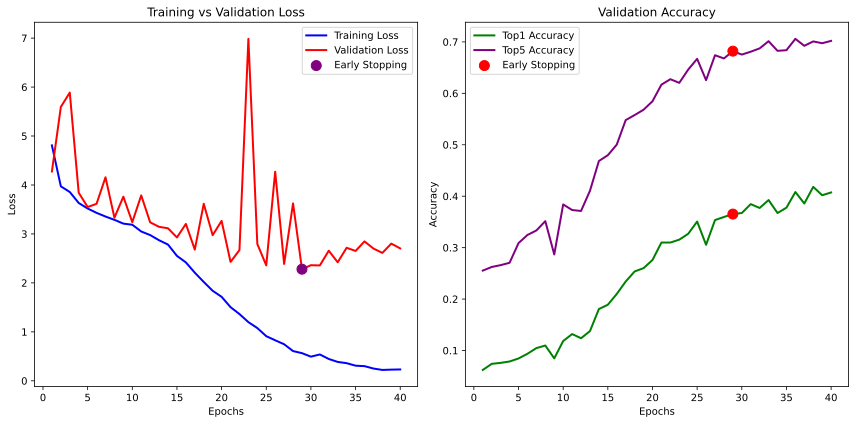

In [22]:
# Plotting the training and validation loss/accuracy curves

# Reading the saved values from the text file
train_losses = read_from_file(train_loss_path)
val_losses = read_from_file(val_loss_path)
top1_accuracies = read_from_file(top1_path)
top5_accuracies = read_from_file(top5_path)

epochs_range = range(1, len(train_losses) + 1)
best_epoch = np.argmin(val_losses) + 1

# Plotting loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Training Loss", color='blue')
plt.plot(epochs_range, val_losses, label="Validation Loss", color='red')
# Highlight the best epoch
plt.scatter(best_epoch, val_losses[best_epoch-1], color='purple', s=100, zorder=5, label='Early Stopping')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, top1_accuracies, label="Top1 Accuracy", color='green')
plt.plot(epochs_range, top5_accuracies, label="Top5 Accuracy", color='purple')
# Highlight the best epoch
plt.scatter(best_epoch, top1_accuracies[best_epoch-1], color='red', s=100, zorder=5, label='Early Stopping')
plt.scatter(best_epoch, top5_accuracies[best_epoch-1], color='red', s=100, zorder=5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

# Save the plot
plot_path = os.path.join(check_name , "plot.png")
plt.savefig(plot_path)

plt.tight_layout()
plt.show()

In [23]:
import torchvision.models as models
from torchvision.models import ResNet50_Weights

MODELS_NUM = 431
MAKE_NUM = 163
car_make_bool = True   ## TODO Remove this line
pretr_checkpoint_name = "checkpoint.pth.tar"
pretr_checkpoint_path = os.path.join(DATA_PATH, pretr_checkpoint_name)

# Function to save the checkpoint
def save_checkpoint(state, filename):
    torch.save(state, filename)

# Function to load the checkpoint
def load_checkpoint(model, optimizer, scheduler, filename):
    if os.path.isfile(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        epoch = checkpoint['epoch']
        best_acc = checkpoint['best_acc']
        print(f"Loaded checkpoint '{filename}' (epoch {epoch})")
        return model, optimizer, scheduler, epoch, best_acc
    else:
        print(f"No checkpoint found at '{filename}'")
        return model, optimizer, scheduler, 0, 0.0


# Function to calculate the accuracy of the model
def accuracy(outputs, labels):
	_, preds = torch.max(outputs, dim=1)   # Get the prediction label for the batch
	return torch.tensor(torch.sum(preds == labels).item() / len(preds))  #sees how many predictions are correct in the batch

####TODO Check if the function is correct
# Function to predict the class of an image
def predict_image(image_path, model, transform):
	image = Image.open(image_path).convert("RGB")
	image = transform(image).unsqueeze(0).to(device)
	outputs = model(image)
	_, preds = torch.max(outputs, 1)
	return preds.item()


In [24]:
###############################
# load previous save model
###############################

import torchvision.models as models
import os

# Load the model
flag = True
if flag:
	# Load the model if it exists
	if os.path.exists(checkpoint_path):
		model = ResNet50()  # Ensure the model architecture matches
		model.load_state_dict(torch.load(checkpoint_path))
		print("Model loaded successfully!",checkpoint_path)

else:
	# Load the model
	model = models.resnet50()
	num_ftrs = model.fc.in_features
	model.fc = nnpo.Linear(num_ftrs, MAKE_NUM)  # Adjust the final layer to match the number of classes
	# Define the optimizer
	optimizer = optim.Adam(model.parameters(), lr=0.001)
	scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
	model, opt, scheduler, start_epoch, best_acc = load_checkpoint(model, optimizer, scheduler, pretr_checkpoint_path)
	print("Model pretrained successfully!")

model.eval()

Model loaded successfully! transf1_su_TranVal_original_param.pt


C:\Users\giuse\AppData\Local\Temp\ipykernel_48156\1911743033.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


ResNet50(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ConvolutionalBlock(
      (main_path): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
      (shortcut_path): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNo

Path: .\Deep_Project\data\cropped_image\classification\test\14\1831\2010\001228e3d5641b.jpg


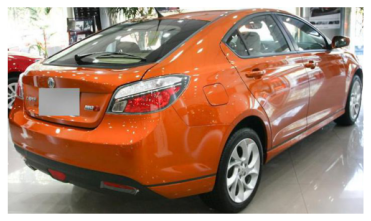

Make: 14
Model: 1831
('MG', 'MG6 hatchback')
Prediction: 14 ('MG', 'Noble M12')


In [62]:
# Load the image
random_number = random.randint(0, len(test_dataset) - 1)
img, car_make, car_model = test_dataset[random_number]
path = os.path.join(test_path, str(car_make), str(car_model))
path = os.path.join(path, os.listdir(path)[0])
path = os.path.join(path, os.listdir(path)[0])
print("Path:", path)

# Show the image
image = Image.open(path).convert("RGB")
imshow(transforms.ToTensor()(image))
print("Make:", car_make)
print("Model:", car_model)

print(get_names(mat_file, [car_make, car_model]))

# Predict the class of the image
img = img.unsqueeze(0).to(device)  # Add a batch dimension and move the image to the device
model.to(device)  # Ensure the model is on the same device as the input
pred = model(img).argmax(dim=1).item()
print("Prediction:", pred, get_names(mat_file, [pred, 0]))

In [26]:
 # Validation loop
model.eval()
model.to(device)	# Ensure the model is on the same device as the input
test_loss = 0
test_acc = 0
with torch.no_grad():
	predictions = []
	true = []
	for batch_x, batch_y, _ in tqdm(test_loader):  # ignoring the third value
		batch_x = batch_x.to(device)
		batch_y = batch_y.to(device)

		y_pred = model(batch_x)

		predictions.append(y_pred)
		true.append(batch_y)
		#print some random images and their predictions
		if random.random() < 0.01:
			_, preds = torch.max(y_pred, 1)
			print("Predictions:", preds)
			print("True labels:", batch_y)

	predictions = torch.cat(predictions, axis=0)
	true = torch.cat(true, axis=0)

	test_loss = loss_fn(predictions, true)
	test_acc = (predictions.argmax(dim=1) == true).float().mean()


 45%|████▍     | 208/467 [00:26<00:32,  8.00it/s]

Predictions: tensor([162, 162, 157, 140, 102, 162, 162, 162, 122, 162,  69, 162, 162, 162,
        162, 162, 162, 162,  69, 102, 162, 162, 162, 162,  69, 162,  97,  35,
        162, 105, 162, 105], device='cuda:0')
True labels: tensor([162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162,
        162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162,
        162, 162, 162, 162], device='cuda:0')


 48%|████▊     | 224/467 [00:28<00:33,  7.27it/s]

Predictions: tensor([142,  97,  28,  78,  28,  28,  28,  28, 118, 102, 158,  28,  71,  71,
         28, 131, 114, 131,  71,  28,  28,  28,  28,  28, 142,  11,  28,  37,
        140,  28,  28,  28], device='cuda:0')
True labels: tensor([28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28],
       device='cuda:0')


 76%|███████▋  | 357/467 [00:46<00:17,  6.31it/s]

Predictions: tensor([114, 162,  78, 152,  75, 114,  75, 150,  75, 111, 157,  97, 152,  27,
        152, 158, 158,  75, 108, 140,  54,  75, 158,  27, 158, 102, 162,  76,
         39,  73,  73,  69], device='cuda:0')
True labels: tensor([75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75,
        75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 76, 76],
       device='cuda:0')


100%|██████████| 467/467 [00:59<00:00,  7.87it/s]


In [27]:
from torchmetrics.functional import accuracy
top1_accu = accuracy(predictions, true, task='multiclass', num_classes=163, top_k=1)
top5_accu = accuracy(predictions, true, task='multiclass', num_classes=163, top_k=5)

print(f"loss: {test_loss}, TOP1 accuracy: {top1_accu}, TOP5 accuracy: {top5_accu}")

loss: 2.1644630432128906, TOP1 accuracy: 0.41997456550598145, TOP5 accuracy: 0.7170493602752686
